In [55]:
import numpy as np
import random
import torch
import math
from Bio import SeqIO
import Bio.PDB
import pickle as pickle
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import LayerNorm
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn.models import MLP
from torch_geometric.data import Data
from torch import Tensor
from torch_geometric.utils import softmax
from torch_geometric.nn.aggr import MeanAggregation
import matplotlib.pyplot as plt
import os
from Bio import PDB
from rdkit import Chem
import blosum as bl
from graph_utils import *

In [56]:
class CFG:
    pdbfiles: str = "/home/paul/Desktop/BioHack-Project-Walkthrough/pdbind-refined-set/"
    AA_mol2_files: str = "/home/paul/Desktop/BioHack-Project-Walkthrough/AA_mol2/"
    home: str = '/home/paul/Desktop/BioHack-Project-Walkthrough'

In [57]:
def uniID2seq(uniID,map_distance):
    atom_name = 'CA'
    contact_map, index, chain_info = calc_contact_map(uniID,map_distance)
    pdb_code = uniID
    pdb_filename = uniID+"_pocket_clean.pdb"
    structure = Bio.PDB.PDBParser(QUIET = True).get_structure(pdb_code, (CFG.pdbfiles +'/'+pdb_code+'/'+pdb_filename))
    model = structure[0]
    
    seq = []
    
    for i in index:
        seq.append(model[chain_info[i][0]][chain_info[i][1]].get_resname())

    return seq

In [58]:
def createMask(graph,indicies,num_masked):
    size = graph.x.size()[0]
    protein_mask = [False]*size
    true_mask = [True] * num_masked
    indicies_mask = [False]*(len(indicies) - num_masked)
    design_mask = np.hstack((true_mask,indicies_mask))
    random.shuffle(design_mask)
    
    count = 0
    for i in range(len(protein_mask)):
        if i in indicies:
            protein_mask[i] = design_mask[count]
            count += 1
            
    for i, j in enumerate(protein_mask):
        if j == 1.0:
            protein_mask[i] = True
    
    return protein_mask

In [59]:
graph_list = torch.load('binding_pocket_graphs.pt')

smallest = 5
count = 0
graph_list_clean = []
for entry in graph_list:
    if len(entry.designable_indicies) >= smallest:
        graph_list_clean.append(entry)
        count += 1
        
for i, graph in enumerate(graph_list_clean):
    graph_list_clean[i].mask = createMask(graph,graph.designable_indicies,int(len(graph.designable_indicies)))
    graph_list_clean[i].inv_mask = [not i for i in graph_list_clean[i].mask]

In [60]:
group_assignment = torch.load('group_assignment_30p.pt')
group_size = torch.load('group_size_30p.pt')

for i, graph in enumerate(graph_list_clean):
    graph_list_clean[i].group = group_assignment[graph.label]

In [61]:
train_name = torch.load('train_name.pt')
test_name = torch.load('test_name.pt')

train_data = []
val_data = []

for graph in graph_list_clean:
    if graph.label in train_name:
        train_data.append(graph)
    elif graph.label in test_name:
        val_data.append(graph)

Define Model

In [62]:
class Graph_Attn(MessagePassing):
    def __init__(self, in_channels, edge_attr_dim, hidden_channels, out_channels, nheads = 8, attn_dropout = 0.5, mlp_dropout = 0.0, neg_slope = 0.2):
        super(Graph_Attn, self).__init__(node_dim=0, aggr='add')  # 'add' aggregation for summing messages
        
        self.in_channels = float(in_channels)
        self.neg_slope = neg_slope
        self.attn_dropout = attn_dropout
        self.relu = nn.LeakyReLU(negative_slope = neg_slope)
        
        self.nheads = nheads
        self.c = hidden_channels        
        
        self.Wq = Linear(in_channels, nheads*hidden_channels)
        self.Wz = Linear((in_channels+edge_attr_dim), nheads*hidden_channels)
        self.Wv = Linear((in_channels+edge_attr_dim), nheads*hidden_channels)
        self.W0 = Linear(nheads*hidden_channels, out_channels)
        #self.W0 = MLP(in_channels=nheads*out_channels, hidden_channels= 2*nheads*out_channels ,out_channels=out_channels, num_layers=2, norm = 'layer', dropout = mlp_dropout)
        
        self.dropout = nn.Dropout(p = self.attn_dropout)

    def forward(self, x, edge_index, edge_attr)-> Tensor:
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        return self.W0(out.view(-1,self.nheads*self.c))

    def message(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor, index)-> Tensor:
        rij = torch.cat([x_j , edge_attr], dim=-1)
        qi = self.Wq(x_i).view(-1,self.nheads,self.c)
        zij = self.Wz(rij).view(-1,self.nheads,self.c)
        vij = self.Wv(rij).view(-1,self.nheads,self.c)
        mij = torch.sum(qi * zij * ((1.0/self.in_channels) ** 0.5), dim = -1)
        alphaij = softmax(mij, index)
        alphaij = self.dropout(alphaij)
        msg = vij*alphaij.unsqueeze(-1)
        return  msg
    
class MLP_Conv_edges(MessagePassing):
    def __init__(self, in_channels, edge_attr_dim, hidden_channels, out_channels):
        super(MLP_Conv_edges, self).__init__(aggr='add')  # 'add' aggregation for summing messages
        #self.mlp = nn.Sequential(
        #    nn.Linear(2*in_channels + edge_attr_dim, hidden_channels),
        #    nn.ReLU(),
        #    nn.Linear(hidden_channels, hidden_channels),
        #    nn.ReLU(),
        #    nn.Linear(hidden_channels, out_channels)
        #    
        #)
        self.mlp=MLP(in_channels= 2 * in_channels + edge_attr_dim, hidden_channels= hidden_channels,out_channels=out_channels, num_layers=2, norm = 'layer', dropout = 0.1, act = 'gelu')

    def forward(self, x, edge_index, edge_attr)-> Tensor:
        return self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor)-> Tensor:
        return self.mlp(torch.cat([x_j, x_i, edge_attr], dim=-1))
    
class Encoder_Layer(torch.nn.Module):
    def __init__(self, node_size, edge_size, hidden_size):
        super().__init__()
        self.dropout = nn.Dropout(p = 0.1)
        self.msg1 = Graph_Attn(node_size,edge_size,hidden_size,node_size, nheads = 3)
        #self.msg1 = MLP_Conv_nodes(node_size,edge_size,hidden_size,node_size)
        self.norm_node1 = LayerNorm(node_size, mode = 'node')
        self.norm_node2 = LayerNorm(node_size, mode = 'node')
        self.norm_edge1 = LayerNorm(edge_size, mode = 'node')
        #self.feed_forward = MLP(in_channels=node_size, hidden_channels= 4*node_size,out_channels=node_size, num_layers=2, norm = 'layer', dropout = 0.1)
        self.feed_forward = MLP(in_channels=node_size, hidden_channels= 4*node_size,out_channels=node_size, num_layers=2, norm = 'layer', dropout = 0.1, act = 'gelu')
        self.edge_message = MLP_Conv_edges(node_size,edge_size,int(4*hidden_size),edge_size)
        
    def forward(self, x, edge_index, edge_attr):
        msg = self.msg1(x,edge_index,edge_attr)
        x1 = self.norm_node1(x + self.dropout(msg))
        x2 = self.feed_forward(x1)
        x3 = self.norm_node2(x1 + self.dropout(x2))
        edge_msg = self.edge_message(x3,edge_index,edge_attr)
        edge_attr1 = self.norm_edge1(edge_attr + self.dropout(edge_msg))
        return x3, edge_attr1
    
class AA_Classifier(torch.nn.Module):
    def __init__(self):
        super(AA_Classifier, self).__init__()
        self.node_feature_size = 133
        self.node_feature_hidden_size = 128
        self.node_feature_size_out = 133
        self.edge_dim = 114
        self.dropout = 0.1
        self.Droput = nn.Dropout(p = self.dropout)
        #self.ff_out = MLP(in_channels=self.node_feature_size, hidden_channels= 64,out_channels=20, num_layers=2, norm = 'layer', dropout = 0.0)
        self.ff_out = Linear(self.node_feature_size, 20)
        #self.ff_out2 = Linear(self.node_feature_size, 11)
        #self.relu = nn.LeakyReLU(negative_slope = 0.2)
        
        self.conv1 = Encoder_Layer(self.node_feature_size,self.edge_dim,self.node_feature_hidden_size)
        self.conv2 = Encoder_Layer(self.node_feature_size,self.edge_dim,self.node_feature_hidden_size)
        self.conv3 = Encoder_Layer(self.node_feature_size,self.edge_dim,self.node_feature_hidden_size)
        self.conv4 = Encoder_Layer(self.node_feature_size,self.edge_dim,self.node_feature_hidden_size)
        #self.conv5 = Encoder_Layer(self.node_feature_size,self.edge_dim,self.node_feature_hidden_size)
        #self.conv6 = Encoder_Layer(self.node_feature_size,self.edge_dim,self.node_feature_hidden_size)
        #self.conv7 = Encoder_Layer(self.node_feature_size,self.edge_dim,self.node_feature_hidden_size)
        #self.conv8 = Encoder_Layer(self.node_feature_size,self.edge_dim,self.node_feature_hidden_size)
        #self.conv9 = Encoder_Layer(self.node_feature_size,self.edge_dim,self.node_feature_hidden_size)
        
        self.softmax = torch.nn.Softmax(dim=1)
        self.tanh = nn.Tanh()
        
    def forward(self,graph):
        x, edge_index, edge_attr = graph.x,graph.edge_index,graph.edge_attr
        
        x1, new_attr = self.conv1(x, edge_index,edge_attr)
        x1, new_attr = self.conv2(x1, edge_index,new_attr)
        x1, new_attr = self.conv3(x1, edge_index,new_attr)
        x1, new_attr = self.conv4(x1, edge_index,new_attr)
        #x1, new_attr = self.conv5(x1, edge_index,new_attr)
        #x1, new_attr = self.conv6(x1, edge_index,new_attr)    
        #x1, new_attr = self.conv7(x1, edge_index,new_attr)
        #x1, new_attr = self.conv8(x1, edge_index,new_attr)
        #x1, new_attr = self.conv9(x1, edge_index,new_attr)
        
        return self.ff_out(x1)#, self.ff_out2(x1[-1])

Define Decoder

In [63]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.node_feature_size = 133
        self.node_feature_hidden_size = 50
        self.node_feature_size_out = 20
        self.dropout = 0.3
        self.conv1 = GENConv(self.node_feature_size,self.node_feature_hidden_size,aggr = 'mean',edge_dim = 7,num_layer = 3,norm = 'layer')
        self.conv2 = GATv2Conv(self.node_feature_hidden_size,10, edge_dim = 7, heads = 5,concat = True, dropout = self.dropout)
        self.conv3 = GENConv(self.node_feature_hidden_size,self.node_feature_hidden_size,aggr = 'mean',edge_dim = 7,num_layer = 3,norm = 'layer')
        self.conv4 = GATv2Conv(self.node_feature_hidden_size,self.node_feature_size, edge_dim = 7, heads = 5,concat = False, dropout = self.dropout)
        self.drop = nn.Dropout(p = 0.3)
        self.linear1 = nn.Linear(self.node_feature_size,self.node_feature_hidden_size)
        self.linear2 = nn.Linear(self.node_feature_hidden_size,self.node_feature_hidden_size)
        self.linear3 = nn.Linear(self.node_feature_hidden_size,self.node_feature_size_out)
        self.ReLu = nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self,graph):
        x, edge_index, edge_attr = graph.x,graph.edge_index,graph.edge_attr
        x1 = self.conv1(x, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x1 = self.conv2(x1, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x1 = self.conv3(x1, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x1 = self.conv4(x1, edge_index,edge_attr)
        x1 = x1[-1]
        x1 = torch.tanh(x1)
        x1 = self.drop(x1)
        x1 = self.linear1(x1)
        x1 = self.drop(x1)
        x1 = self.ReLu(x1)
        x1 = self.linear2(x1)
        x1 = self.ReLu(x1)
        x1 = self.linear3(x1)
        return x1
    
    def encode(self,graph):
        x, edge_index, edge_attr = graph.x,graph.edge_index,graph.edge_attr
        x1 = self.conv1(x, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x1 = self.conv2(x1, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x1 = self.conv3(x1, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x1 = self.conv4(x1, edge_index,edge_attr)
        x1 = x1[-1]
        x1 = torch.tanh(x1)
        return x1
    
    def decode(self,encoding):
        x1 = self.linear1(encoding)
        x1 = self.drop(x1)
        x1 = self.ReLu(x1)
        x1 = self.linear2(x1)
        x1 = self.ReLu(x1)
        x1 = self.linear3(x1)
        return x1

In [64]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AA_Classifier()
model.load_state_dict(torch.load(CFG.home + '/model_weights.pt'))
model.to(DEVICE)
model.eval()

#decoder = Net()
#decoder.load_state_dict(torch.load('AA_encoder_11172023.pt'))
#decoder.to(DEVICE)
#decoder.eval()

percent = 0
counter = 0
sequences = []
true_sequences = []
full_item = []
for graph in val_data:
    #graph.mask = createMask(graph,graph.designable_indicies,int(len(graph.designable_indicies)))
    #graph.inv_mask = graph.mask
    full_seq = uniID2seq(graph.label,12.0)
    true_seq = []

    for i in range(len(full_seq)):
        if graph.mask[i] == True:
            true_seq.append(full_seq[i])
            true_sequences.append(full_seq[i])


    with torch.no_grad():

        #Mask Designable Site
        for i,indicator in enumerate(graph.mask):
            if indicator == True:
                graph.x[i] = torch.zeros(len(graph.x[0]))

        #Run Model
        output = model(graph.to(DEVICE))

    #AAs to Decode
    predictions = output[graph.mask]

    #with torch.no_grad():
    #    decoded_AAs = [decoder.decode(AA).to('cpu') for AA in predictions]

    Amino_Acid_x_label = [i for i in OHE_dict]


    Softmax = nn.Softmax(dim = 1)
    predictions = Softmax(predictions)
    seq = []

    for site, AA in enumerate(predictions):
        #plt.bar(Amino_Acid_x_label,AA.to('cpu').detach().numpy())
        #plt.show()
        for i, res in enumerate(OHE_dict):
            if AA[i] == max(AA):
                seq.append(res)
                sequences.append(res)
        
   
    hit = 0
    for i in range(len(seq)):
        if len(seq) == len(true_seq):
            if seq[i] == true_seq[i]:
                hit += 1
        else:
            counter += 1

    if len(seq) == 0:
        print(f'Bad!: {graph.label}')
        #counter += 1
    else:
        percent += (hit/float(len(seq)))*100.0
        full_item.append([graph.label,seq,true_seq,(hit/float(len(seq)))*100.0, full_seq, graph.mask])
        
    graph.to('cpu')

        

total_percent = percent/(float(len(val_data)) - counter)

Predicted Sequences AA Frequency

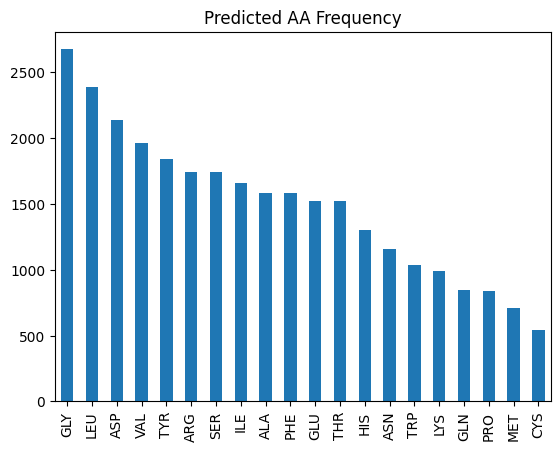

In [70]:
import pandas as pd
pd.Series(sequences).value_counts(sort=True).plot(kind='bar')
plt.title('Predicted AA Frequency')
plt.show()

True Sequences AA Frequency

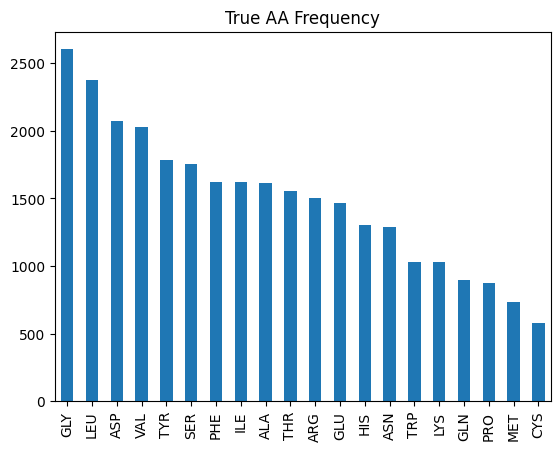

In [71]:
pd.Series(true_sequences).value_counts(sort=True).plot(kind='bar')
plt.title('True AA Frequency')
plt.show()

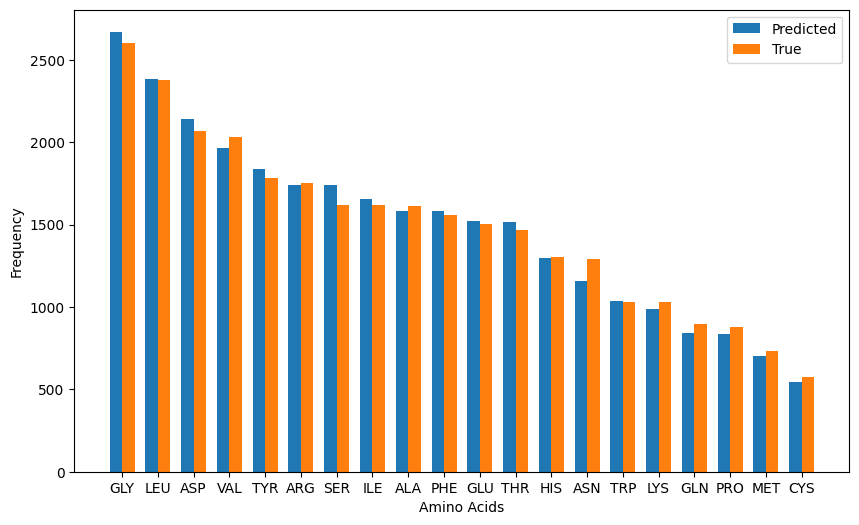

In [81]:
Predicted_AA_counts = pd.Series(sequences).value_counts(sort=True)
True_AA_counts = pd.Series(true_sequences).value_counts(sort=True)

categories = list(Predicted_AA_counts.index)
values1 = Predicted_AA_counts.tolist()
values2 = True_AA_counts.tolist()

# Set the positions of the bars on the x-axis
ind = range(len(categories))

# Width of each bar
width = 0.35

# Create the grouped bar plot
plt.figure(figsize=(10, 6))
plt.bar(ind, values1, width, label='Predicted')
plt.bar([x + width for x in ind], values2, width, label='True')

# Add labels and title
plt.xlabel('Amino Acids')
plt.ylabel('Frequency')
plt.xticks([x + width / 2 for x in ind], categories)
plt.legend()

# Show plot
plt.show()

Text(0, 0.5, 'Sequence Recovery %')

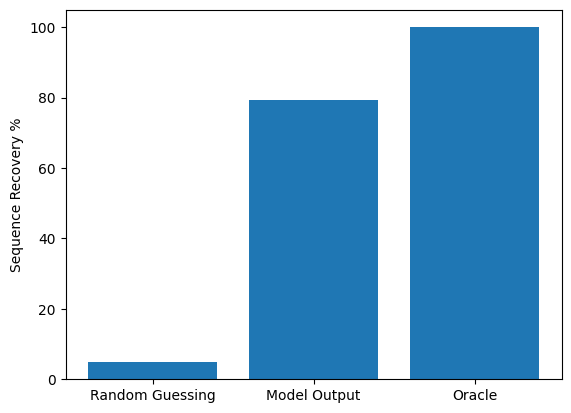

In [83]:
x = ['Random Guessing','Model Output', 'Oracle']
y = [5.0 , total_percent, 100.0]
plt.bar(x, y)
plt.ylabel('Sequence Recovery %')


In [21]:
losses = torch.load('loss.pt')

In [22]:
train_loss = []
val_loss = []

for i in losses:
    train_loss.append(i[0].detach().numpy())
    val_loss.append(i[1].detach().numpy())

In [23]:
epochs = np.linspace(1,len(train_loss),len(train_loss))

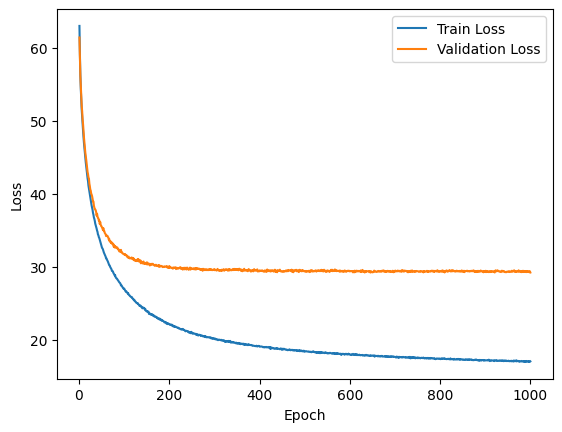

In [24]:
plt.plot(epochs,train_loss,label = 'Train Loss')
plt.plot(epochs,val_loss, label = 'Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [25]:
percentages = [i[3] for i in full_item]

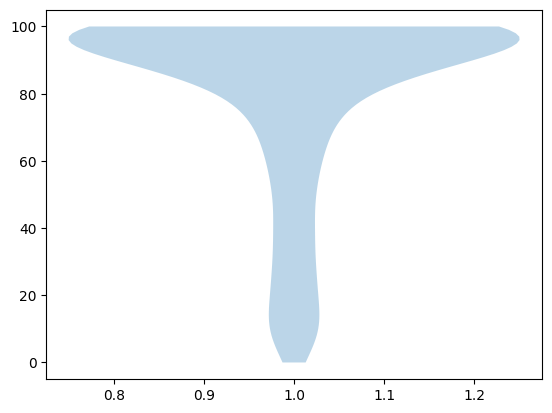

In [26]:
plt.violinplot(percentages, showextrema = False)
plt.show()

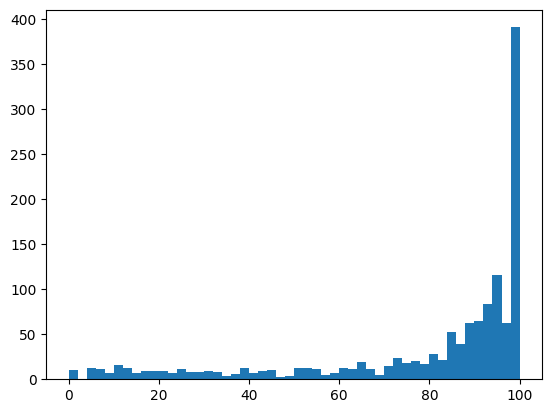

In [27]:
plt.hist(percentages, bins = 50)
plt.show()

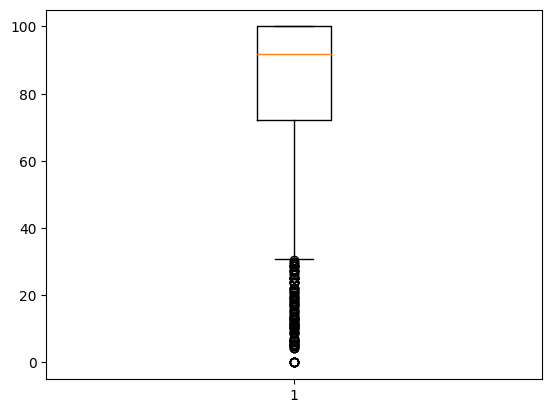

In [28]:
plt.boxplot(percentages)
plt.show()

In [29]:
names = [i.label for i in val_data]
train_names =[i.label for i in train_data]

In [30]:
count =0
for i in names:
    if i in train_names:
        count+=1
        
print(count)

0


In [31]:
sequences = []
for i in full_item:
    pred_seq = []
    idx = []
    count = 0
    for j in range(len(i[4])):
        if i[5][j] == True:
            pred_seq.append(i[1][count])
            idx.append(j+1)
            count+=1
        else:
            pred_seq.append(i[4][j])

    sequences.append([i[0],i[4],pred_seq,idx])

In [32]:
columns = ['Name','True Sequence','Predicted Sequence','Indexes']
df = pd.DataFrame(sequences, columns=columns)

In [34]:
df.to_excel("Sequence Results.xlsx") 

In [35]:
sequences = []
for i in full_item:
    sequences.append([i[1],i[2]])

In [36]:
hit = 0
count = 0
for seqs in sequences:
    for j in range(len(seqs[1])):
        if seqs[0][j] == seqs[1][j]:
            hit += 1
        count += 1

print(hit/count)

0.8005313782202192


In [37]:
length = []
per = []
for i in full_item:
    length.append(len(i[1])/len(i[4]))
    per.append(i[3]/100)

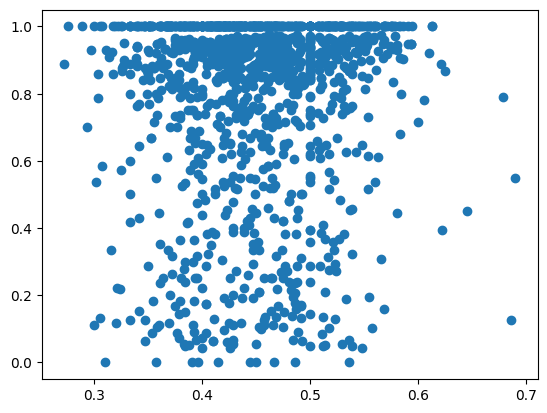

In [38]:
plt.scatter(length,per)

In [39]:
min_num = min(per)
for i, percentage in enumerate(per):
    if percentage == min_num:
        print(full_item[i])    

['1xff', ['TYR', 'SER', 'ASN', 'VAL', 'CYS', 'ARG', 'ALA', 'GLY', 'LYS', 'ILE', 'PRO', 'SER', 'PHE', 'SER', 'THR', 'ASP', 'ALA', 'GLU'], ['CYS', 'HIS', 'THR', 'ARG', 'TRP', 'ALA', 'THR', 'HIS', 'ASN', 'HIS', 'HIS', 'ASN', 'GLY', 'ILE', 'ILE', 'THR', 'ASP', 'THR'], 0.0, ['CYS', 'GLY', 'ILE', 'GLY', 'TYR', 'ASP', 'SER', 'HIS', 'THR', 'ARG', 'TRP', 'ALA', 'THR', 'HIS', 'GLY', 'GLU', 'PRO', 'SER', 'ASN', 'ALA', 'HIS', 'HIS', 'VAL', 'HIS', 'ASN', 'GLY', 'ILE', 'ILE', 'HIS', 'SER', 'GLU', 'THR', 'ASP', 'THR', 'GLU', 'ILE', 'ALA', 'TYR', 'GLY', 'SER'], [True, False, False, False, False, False, False, True, True, True, True, True, True, True, False, False, False, False, True, False, True, False, False, True, True, True, True, True, False, False, False, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]]
['1pgp', ['GLY', 'TYR', 'ALA', 'ASN', 'GLU', 'LEU',

In [40]:
max_num = max(per)
for i, percentage in enumerate(per):
    if percentage == max_num:
        print(full_item[i])

['5j6m', ['LEU', 'SER', 'ASN', 'SER', 'ASP', 'ALA', 'LYS', 'ASP', 'GLY', 'ILE', 'GLY', 'MET', 'ASP', 'LEU', 'ASN', 'PHE', 'TYR', 'VAL', 'THR', 'TRP', 'THR', 'VAL'], ['LEU', 'SER', 'ASN', 'SER', 'ASP', 'ALA', 'LYS', 'ASP', 'GLY', 'ILE', 'GLY', 'MET', 'ASP', 'LEU', 'ASN', 'PHE', 'TYR', 'VAL', 'THR', 'TRP', 'THR', 'VAL'], 100.0, ['PHE', 'GLU', 'LEU', 'ILE', 'SER', 'ASN', 'SER', 'SER', 'ASP', 'ALA', 'LEU', 'ASP', 'LYS', 'ILE', 'ILE', 'ILE', 'VAL', 'ASP', 'THR', 'GLY', 'ILE', 'GLY', 'MET', 'THR', 'LYS', 'ALA', 'ASP', 'LEU', 'ILE', 'ASN', 'ASN', 'ALA', 'GLY', 'VAL', 'GLY', 'PHE', 'TYR', 'ALA', 'TYR', 'VAL', 'THR', 'VAL', 'ILE', 'THR', 'LYS', 'HIS', 'TRP', 'GLU', 'SER', 'PHE', 'THR', 'VAL', 'GLY', 'THR', 'LYS', 'VAL', 'ILE', 'TYR'], [False, False, True, False, True, True, True, False, True, True, False, False, True, False, False, False, False, True, False, True, True, True, True, False, False, False, True, True, False, False, True, False, False, False, False, True, True, False, False, False, 

In [41]:
group_assignment = torch.load('group_assignment_30p.pt')
group_size = torch.load('group_size_30p.pt')

In [42]:
group_percent = {}
for i in full_item:
    if group_assignment[i[0]] in group_percent:
        group_percent[group_assignment[i[0]]] += [i[3]]
    else:
        group_percent.update({group_assignment[i[0]]:[i[3]]})

In [43]:
for i in group_percent:
    group_percent[i] = sum(group_percent[i])/len(group_percent[i])

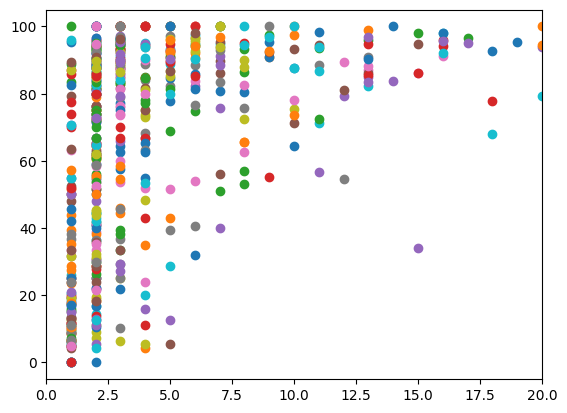

In [44]:
for i in group_percent:
    plt.scatter(group_size[i],group_percent[i])

plt.xlim(0,20)
plt.show()

In [45]:
size2percent = {}
for i in group_percent:
    if group_size[i] in size2percent:
        size2percent[group_size[i]] += [group_percent[i]]
    else:
        size2percent.update({group_size[i]:[group_percent[i]]})

In [46]:
sum(size2percent[1])/len(size2percent[1])

29.239286731004846

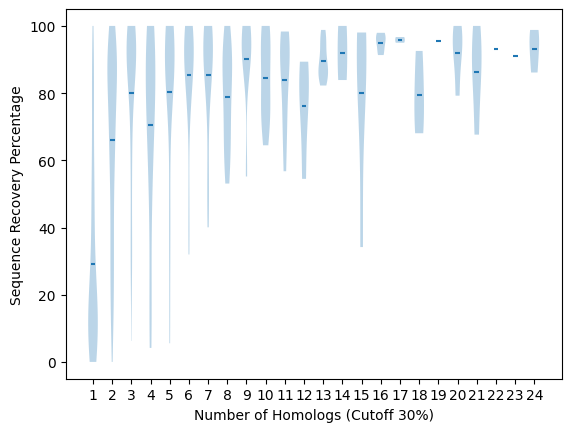

In [47]:
data = []
ticks = []
for i in range(1,25):
    data.append(size2percent[i])
    ticks.append(str(i))
plt.violinplot(data, showextrema = False, showmeans = True)
plt.xticks([j for j in range(1,25)], labels = ticks)
#plt.title('Weighted Training')
plt.xlabel('Number of Homologs (Cutoff 30%)')
plt.ylabel('Sequence Recovery Percentage')
plt.show()